# Project - Home Credit Default Risk

In this project we will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

In [ ]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
randomness = 0

## Introduction

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

In [ ]:
# From Google Colab
from google.colab import drive
drive.mount('/content/drive')

app_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AnyoneAI/Sprint 3/application_train.csv")
app_test  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AnyoneAI/Sprint 3/application_test.csv")

In [4]:
# From disk
app_train = pd.read_csv("./application_train.csv")
app_test  = pd.read_csv("./application_test.csv")

### Exploratory Data Analysis

**Dataset Basics**

In [5]:
print(f"Train dataset shape: {app_train.shape}")
print(f"Test dataset shape:   {app_test.shape}")

Train dataset shape: (307511, 122)
Test dataset shape:   (48744, 121)


In [6]:
print("Name of columns:")
print(app_train.columns.values)

Name of columns:
['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTR

In [7]:
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)
display(app_train.head(5).transpose())
pd.reset_option("max_rows")

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5


Amount of loans that were repaid(0):     282686 - 91.93% of data
Amount of loans that weren't repaid(1):   24825 -  8.07% of data



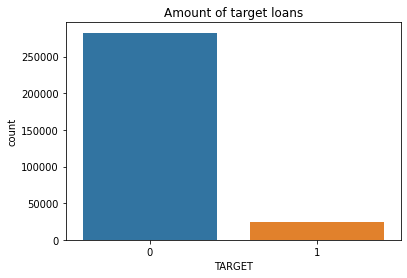

In [8]:
pay     = len(app_train[app_train['TARGET'] == 0])
not_pay = len(app_train[app_train['TARGET'] == 1])

print("Amount of loans that were repaid(0):".ljust(40), str(pay).rjust(6), f"- {pay/len(app_train):.2%} of data")
print("Amount of loans that weren't repaid(1):".ljust(40), str(not_pay).rjust(6), f"-  {not_pay/len(app_train):.2%} of data" + "\n")

sns.countplot(data=app_train, x="TARGET").set(title="Amount of target loans")
plt.show()

In [9]:
pd.DataFrame(app_train.dtypes.value_counts(), columns=["Amount of columns"])

,Amount of columns
float64,65
int64,41
object,16


In [10]:
pd.DataFrame(app_train.select_dtypes(include=object).nunique(), columns=["Number of distinc values"])

,Number of distinc values
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


In [11]:
pd.DataFrame((app_train.isna().sum()/len(app_train)).sort_values(ascending=False).head(20), columns=["Percentage of Nan"])

,Percentage of Nan
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MODE,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MEDI,0.683550


**Analyzing distribution of variables**

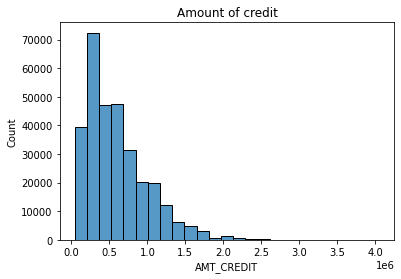

In [12]:
sns.histplot(app_train, x="AMT_CREDIT", bins=25).set(title="Amount of credit")
plt.show()

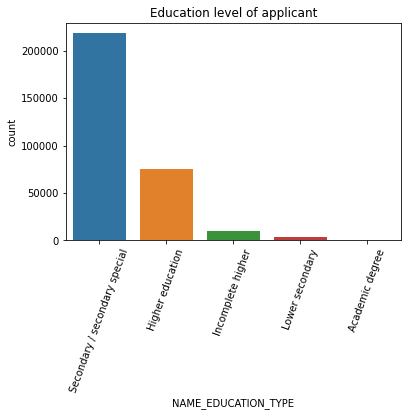

,Count,Percentage
Secondary / secondary special,218391,0.710189
Higher education,74863,0.243448
Incomplete higher,10277,0.033420
Lower secondary,3816,0.012409
Academic degree,164,0.000533


In [13]:
sns.countplot(data=app_train, x="NAME_EDUCATION_TYPE").set(title="Education level of applicant")
plt.xticks(rotation=70)
plt.show()

auxiliar = pd.DataFrame(app_train["NAME_EDUCATION_TYPE"].value_counts()).rename(columns={"NAME_EDUCATION_TYPE":"Count"})
auxiliar["Percentage"] = auxiliar["Count"]/len(app_train)
display(auxiliar)

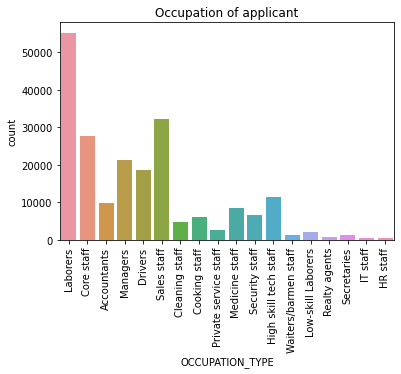

In [14]:
sns.countplot(data=app_train, x="OCCUPATION_TYPE").set(title="Occupation of applicant")
plt.xticks(rotation=90)
plt.show()

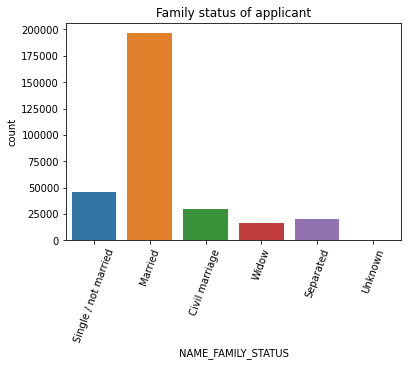

In [15]:
sns.countplot(data=app_train, x="NAME_FAMILY_STATUS").set(title="Family status of applicant")
plt.xticks(rotation=70)
plt.show()

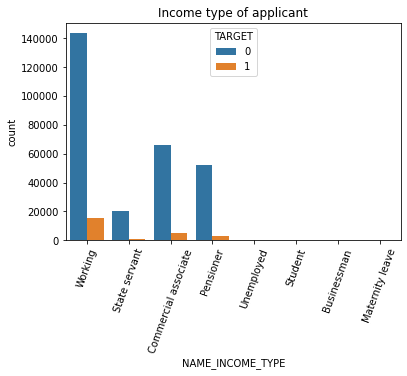

In [16]:
sns.countplot(data=app_train, x="NAME_INCOME_TYPE", hue="TARGET").set(title="Income type of applicant")
plt.xticks(rotation=70)
plt.show()

## Preprocessing

We are going to create functions to perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

In [17]:
X_train = app_train.drop(columns=["SK_ID_CURR", "TARGET"], axis=1)
y_train = app_train["TARGET"]
X_test  = app_test.drop(columns=["SK_ID_CURR"], axis=1)

In [18]:
def outlier(X_train):
    '''
    Pick outliers values identified in the dataset.

    Input: pd.DataFrame with raw data about loans.
    ---
    Output: pd.DataFrame with NaN values in the outlier positions.
    '''

    X_train.loc[X_train["DAYS_EMPLOYED"] > 0, "DAYS_EMPLOYED"] = np.nan
    X_train.loc[X_train["AMT_INCOME_TOTAL"] > 10000000, "AMT_INCOME_TOTAL"] = np.nan
    X_train.loc[X_train["OWN_CAR_AGE"] > 50, "OWN_CAR_AGE"] = np.nan


def impute(X_train, X_test):
    '''
    Change NaN values with an apropiate value: median for numerical features
    and mode for categorical features.

    Input: pd.DataFrame with NaN values.
    ---
    Output: pd.DataFrame without NaN values. Those are changed with
    corrected values.
    '''

    n_columns = list(X_train.select_dtypes(exclude=object).columns)
    o_columns = list(X_train.select_dtypes(include=object).columns)

    imputer = SimpleImputer(strategy="median")
    X_train[n_columns] = imputer.fit_transform(X_train[n_columns])
    X_test[n_columns]  = imputer.transform(X_test[n_columns])

    imputer = SimpleImputer(strategy="most_frequent")
    X_train[o_columns] = imputer.fit_transform(X_train[o_columns])
    X_test[o_columns]  = imputer.transform(X_test[o_columns])


def encoding(X_train, X_test):
    '''
    Encoding of categorical features.

    Input: pd.DataFrame with categorical features.
    ---
    Output: pd.DataFrame with categrical features encoded. Test dataset
    transform with same encoder.
    '''

    n_categories = pd.DataFrame(X_train.select_dtypes(include=object).nunique(), columns=["Amount"])
    bi_columns = list(n_categories[n_categories["Amount"] == 2].index)
    non_bi_columns = list(n_categories[n_categories["Amount"] > 2].index)

    for column in bi_columns:
        encoder = LabelEncoder()
        X_train[column] = encoder.fit_transform(X_train[column])
        X_test[column]  = encoder.transform(X_test[column])


    encoder = OneHotEncoder(drop="first", dtype=int)

    encoder_data = encoder.fit_transform(X_train[non_bi_columns]).toarray()
    X_train[encoder.get_feature_names_out()] = encoder_data
    X_train.drop(axis=1, labels=non_bi_columns, inplace=True)

    encoder_data = encoder.transform(X_test[non_bi_columns]).toarray()
    X_test[encoder.get_feature_names_out()] = encoder_data
    X_test.drop(axis=1, labels=non_bi_columns, inplace=True)


def scaling(X_train, X_test):
    '''
    Scaling of numerical features.

    Input: pd.DataFrame with numerical features without being scaled.
    ---
    Output: pd.DataFrame with numerical features scaled. Test dataset
    scaled with same scaler.
    '''

    n_columns = list(X_train.select_dtypes(exclude=object).columns)
    scaler = StandardScaler()
    X_train[n_columns] = scaler.fit_transform(X_train[n_columns])
    X_test[n_columns]  = scaler.transform(X_test[n_columns])


def preprocessing(X_train, X_test):
    '''
    Preprocessing of the train and test datasets
    '''

    outlier(X_train)
    impute(X_train, X_test)
    encoding(X_train, X_test)
    scaling(X_train, X_test)

In [ ]:
preprocessing(X_train, X_test)

## Training Models

### Baseline: LogisticRegression

In [21]:
baseline = LogisticRegression(C=0.1, max_iter=500, random_state=randomness)
baseline.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=500, random_state=0)

In [22]:
predicted_values = baseline.predict_proba(X_test)
predicted_values = predicted_values[:, 1]

y_pred = pd.DataFrame()
y_pred["TARGET"] = predicted_values
y_pred.set_index(app_test["SK_ID_CURR"], inplace=True)

y_pred.to_csv("log_pred.csv", index=True)

In [23]:
# Private AUC ROC:

auc_roc_log = 0.63035

### Training a Random Forest Classifier 

In [24]:
forest_c = RandomForestClassifier(n_jobs=-1, random_state=randomness)
init_time = time()

forest_c.fit(X_train, y_train)
print(f"Done in {int(time() - init_time)} seconds.")

Done in 144 seconds.


In [25]:
### Complete in this cell: predict test data and save csv
predicted_values = forest_c.predict_proba(X_test)
predicted_values = predicted_values[:, 1]

y_pred = pd.DataFrame()
y_pred["TARGET"] = predicted_values
y_pred.set_index(app_test["SK_ID_CURR"], inplace=True)

y_pred.to_csv("forest_pred.csv", index=True)

In [26]:
# Private AUC ROC:

auc_roc_forest = 0.68305

### Randomized Search with Cross Validation

In [27]:
init_time = time()

hyperparameter_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 13, 15, 18, 20, 22, 25, 28],
 'min_samples_leaf': [4, 6, 8, 10, 12, 15],
 'min_samples_split': [2, 5, 6, 7, 8, 10],
 'n_estimators': [150, 200, 250, 300]
}

forest_c = RandomForestClassifier(n_jobs=-1, random_state=randomness)
randomsearcher = RandomizedSearchCV(forest_c,
                                    hyperparameter_grid,
                                    scoring="roc_auc",
                                    n_iter=3,
                                    cv=3,
                                    random_state=randomness)

search = randomsearcher.fit(X_train, y_train)

print(f"Done in {int(time() - init_time)} seconds.\n")

print(search.best_params_)

Done in 2249 seconds.

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 18, 'bootstrap': False}


In [29]:
predicted_values = search.predict_proba(X_test)
predicted_values = predicted_values[:, 1]

y_pred = pd.DataFrame()
y_pred["TARGET"] = predicted_values
y_pred.set_index(app_test["SK_ID_CURR"], inplace=True)

y_pred.to_csv("forest_rscv.csv", index=True)

In [30]:
# Private AUC ROC con cross valitation of 3 groups:

# n_iter:3
auc_roc_rscv_03 = 0.72654

# n_iter:10
auc_roc_rscv_10 = 0.72837

# n_iter:30
auc_roc_rscv_30 = 0.72941

### Optional: Training a LightGBM model 

In [31]:
hyperparameter = {
    'num_leaves': [15, 30, 60],
    'max_depth': [5, 10, 15],
    'min_child_samples': [25, 50, 75],
    'n_estimators': [100, 150, 200],
    'class_weight': ['balanced'],
    'objective': ['binary'],
    'learning_rate': [0.03, 0.05, 0.07]
}

model = RandomizedSearchCV(lgb.LGBMClassifier(),
                           hyperparameter,
                           random_state=randomness,
                           scoring='roc_auc',
                           cv=4,
                           n_iter=3)

init_time = time()
model.fit(X_train, y_train)

print(f"Done in {int(time() - init_time)} seconds.\n")

Done in 624 seconds.



In [32]:
model.best_params_

{'class_weight': 'balanced',
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_samples': 50,
 'n_estimators': 200,
 'num_leaves': 15,
 'objective': 'binary'}

In [33]:
predicted_values = model.predict_proba(X_test)[:, 1]

y_pred = pd.DataFrame()
y_pred["TARGET"] = predicted_values
y_pred.set_index(app_test["SK_ID_CURR"], inplace=True)

y_pred.to_csv("lgbm_pred_2.csv", index=True)

In [ ]:
# Private AUC ROC:

# n_iter:3 cv:4
auc_roc_lgbm_03_4 = 0.74104

# n_iter:10 cv:5
auc_roc_lgbm_10_5 = 0.74375

### Using Scikit Learn Pipelines 

In [34]:
X_train_2 = app_train.drop(columns=["SK_ID_CURR", "TARGET"], axis=1)
y_train_2 = app_train["TARGET"]
X_test_2  = app_test.drop(columns=["SK_ID_CURR"], axis=1)

In [35]:
numerical_features = X_train_2.select_dtypes(include='number').columns.tolist()
string_features    = X_train_2.select_dtypes(exclude='number').columns.tolist()

outlier(X_train)

# Pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])


# Pipeline for string features
string_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('string', string_pipeline, string_features)
])


new_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', lgb.LGBMClassifier())
])


new_pipeline.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTR

In [36]:
predicted_values = new_pipeline.predict_proba(X_test_2)
predicted_values = predicted_values[:, 1]

y_pred = pd.DataFrame()
y_pred["TARGET"] = predicted_values
y_pred.set_index(app_test["SK_ID_CURR"], inplace=True)

y_pred.to_csv("pipe_pred.csv", index=True)

In [37]:
# Private AUC ROC:

auc_roc_pipe_lgbm = 0.74449